In [127]:
%autosave 15
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats as sps
import scipy.optimize as spo

import math
from collections import namedtuple
from functools import partial
from IPython.display import display, HTML

Autosaving every 15 seconds


In [128]:
data = pd.read_csv('non-parametric.csv', sep=';', names=['id', 'x', 'y'])

#1st parameter is text
ids = data['id'].values[1:].astype('int')
X = data['x'].values[1:].astype('float32')
Y = data['y'].values[1:].astype('float32')
n = len(data) - 1
print('dataset size:', n)

dataset size: 136


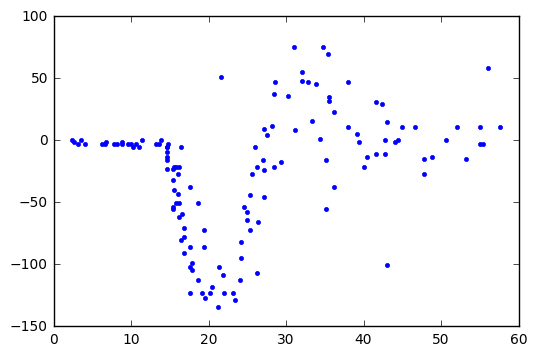

In [129]:
#plt.plot(X, Y)
plt.plot(X, Y, 'b.')

In [132]:
class SplineRegression():
    
    def __init__(self, k = 20):
        self.k = k
        
    def fit(self, x, y):
        self.x = x
        self.y = y
        
    
    
    def createSegmentFunction(self, x, y):
        def getCoefficients(a, b, c, d):
            a3 = (-a + 3 * (b - c) + d) / 6.0
            a2 = (a - 2 * b + c) / 2.0
            a1 = (c - a) / 2.0
            a0 = (a + 4 * b + c) / 6.0
            return a3, a2, a1, a0
        
        x3, x2, x1, x0 = getCoefficients(x[0], x[1], x[2], x[3])
        y3, y2, y1, y0 = getCoefficients(y[0], y[1], y[2], y[3])
        
        def f(t):
            tx = ((x3 * t + x2) * t + x1) * t + x0
            ty = ((y3 * t + y2) * t + y1) * t + y0
            return (tx, ty)
        
        return f

        
    def getMorePoints(self):
        resx, resy = [], [] 
        n = len(self.x)
        for i in range(0, n - 2):
            px = np.concatenate([self.x[max(0, i - 1) : max(i, 1)],
                                 self.x[i : i + 2], 
                                 self.x[min(i + 2, n - 1) : min(i + 3, n)]
                                ])
            py = np.concatenate([self.y[max(0, i - 1) : max(i, 1)],
                                 self.y[i : i + 2],
                                 self.y[min(i + 2, n - 1) : min(i + 3, n)]
                                ])
            f = self.createSegmentFunction(px, py)
            for i in range(self.k + 1):
                x, y = f(i / self.k)
                resx.append(x)
                resy.append(y)
        return resx, resy    
    
    
    def predict(self, curx):
        resx, resy = self.getMorePoints()
        ansx, ansy = resx[0], resy[0]
        for i in range(1, len(resx)):
            if abs(resx[i] - curx) < abs(ansx - curx):
                ansx = resx[i]
                ansy = resy[i]
        return ansy
        

308.300428625 17.5584859434


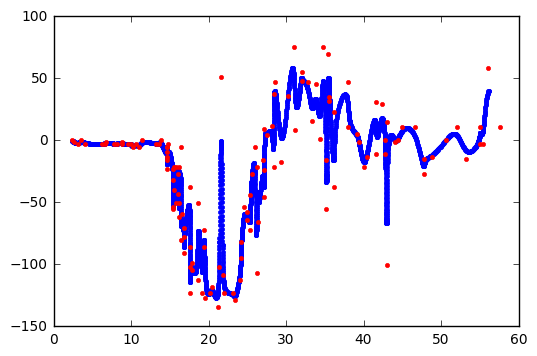

In [133]:
spline = SplineRegression(30)
spline.fit(X, Y)
xx, yy = spline.getMorePoints()

MSE = computeScore(spline, X, Y)
print(MSE, MSE ** (1/2))

plt.plot(xx, yy, 'b.', X, Y, 'r.')

In [134]:
class SmoothingMethodRegression():
    
    def __init__(self, kernel, k):
        self.kernel = kernel
        self.k = k
        
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.gamma = np.array([1 for i in range(len(x))])
        
        work = True
        while work:
            work = False
            new_gamma = list()
            a = list()
            for i in range(len(x)):
                sum1 = 0
                sum2 = 0
                dist = [(np.abs(x[j] - x[i]), j) for j in range(len(x))]
                dist.sort()
                h = dist[self.k][0]
                for j in range(self.k):
                    elem = dist[j]
                    if elem[1] != i:
                        value = self.kernel(elem[0] / h)
                        sum1 += self.gamma[elem[1]] * self.y[elem[1]] * value
                        sum2 += self.gamma[elem[1]] * value
                a.append(sum1 / sum2)
            a = [np.abs(a[i] - y[i]) for i in range(len(x))]
            med = np.median(a)
            for i in range(len(x)):
                new_gamma.append(self.kernel(a[i] / (6 * med)))
            new_gamma = np.array(new_gamma)
            
            for e in (new_gamma - self.gamma):
                if e > 1e-2:
                    work = True
            self.gamma = new_gamma
#         print(self.gamma)

        
        
    def predict(self, x):
        sum1 = 0
        sum2 = 0
        dist = [(np.abs(self.x[i] - x), i) for i in range(len(self.x))]
        dist.sort()
        h = dist[self.k][0]
        skip = 0
        while dist[skip][0] == 0.0:
            skip += 1
        for i in range(skip, skip + self.k):
            elem = dist[i]
            value = self.kernel(elem[0] / h)
            sum1 += self.gamma[elem[1]] * self.y[elem[1]] * value
            sum2 += self.gamma[elem[1]] * value
        result = sum1 / sum2
        return result

In [135]:
def gaussKernel(x):
    return np.exp(- (x ** 2) / 2)

def quadKernel(x):
    return ((1 - x ** 2) ** 2)

def tri(x):
    return ((1 - x ** 3) ** 3)

kernels = [(gaussKernel, "gauss"), (tri, "tri")]

In [136]:
def computeScore(model, x, y):
    acc = 0
    for i in range(len(x)):
        acc += (model.predict(x[i]) - y[i]) ** 2
    return acc / len(x)

In [137]:
results = pd.DataFrame(columns=['kernel', 'k', 'MSE', 'RMSE'])

best_MSE = 3000000000 # mnoga
best = None
for kernel, name in kernels:
    for k in range(7, 30):
        model = SmoothingMethodRegression(kernel, k)
        model.fit(X, Y)
        MSE = computeScore(model, X, Y)
        if MSE < best_MSE:
            best_MSE = MSE
            best = (kernel, k)
        raw = pd.DataFrame([[name, k, MSE, MSE ** (1/2)]], columns=['kernel', 'k', 'MSE', 'RMSE'])
        results = results.append(raw, ignore_index=True)
#         print(name, k, "MSE", MSE, "RMSE", MSE ** (1/2))
display(results)

,kernel,k,MSE,RMSE
0,gauss,7.0,8.929772e+02,29.882725
1,gauss,8.0,9.028462e+02,30.047399
2,gauss,9.0,9.042732e+02,30.071135
3,gauss,10.0,9.008867e+02,30.014774
4,gauss,11.0,9.026268e+02,30.043747
5,gauss,12.0,9.015955e+02,30.026580
6,gauss,13.0,8.997420e+02,29.995699
7,gauss,14.0,8.889546e+02,29.815341
8,gauss,15.0,8.891055e+02,29.817872
9,gauss,16.0,8.971543e+02,29.952533


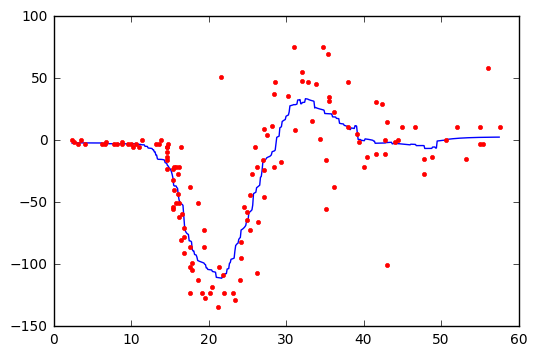

In [138]:
best_smooth = SmoothingMethodRegression(best[0], best[1])
best_smooth.fit(X, Y)

X_new = np.arange(min(X), max(X), 0.1)
# print(max(X))
Y_new = [best_smooth.predict(x) for x in X_new]
plt.plot(X_new, Y_new, 'b')
plt.plot(X, Y, 'r.')